# Face recognition using SVM and kernel trick

# Dataset description

This assignment asks you to build a classifier trained on face images. First, let's load the required dataset and see what it is. 

The table contains "straightened" representations of images of people's faces.

Initially, each image is a matrix of size $62 \times 47$ whose values are presumably normalized to a range $[0, 1]$ from the range $[0, 255] \cap \mathbb Z$. The values themselves are responsible for the intensity of the pixel: the larger the value, the lighter the pixel.

Note, from the image (or, what is the same thing, matrix) of size $62 \times 47$ we get a vector of $2914 = 62 \cdot 47$ length.

The column <code>label</code> is responsible for the name of the person depicted in the picture.

In [61]:
import pandas as pd
df = pd.read_csv('persons_pics_train.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell


Let's make sure that we actually see images of people's faces. Let's take the first $15$ rows from the initial dataframe and build the images corresponding to them.

In [62]:
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

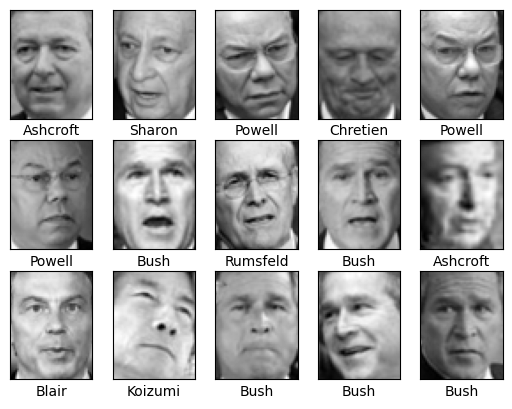

In [63]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')    

Larger

(-0.5, 46.5, 61.5, -0.5)

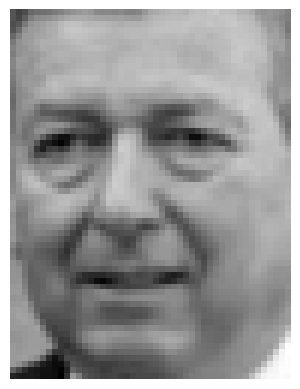

In [64]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# A bit of mischief

Determine the number of different people whose pictures are contained in the dataset.

In [65]:
len(df['label'].unique())

12

Construct a histogram of the distribution of objects by class and calculate the proportion of objects in each class.

In [66]:
dict(df.groupby(by = 'label').count().iloc[:,0]/len(df))

{'Ariel Sharon': 0.049019607843137254,
 'Colin Powell': 0.1515837104072398,
 'Donald Rumsfeld': 0.07767722473604827,
 'George W Bush': 0.3401206636500754,
 'Gerhard Schroeder': 0.07013574660633484,
 'Hugo Chavez': 0.04524886877828054,
 'Jacques Chirac': 0.033182503770739065,
 'Jean Chretien': 0.03544494720965309,
 'John Ashcroft': 0.033936651583710405,
 'Junichiro Koizumi': 0.038461538461538464,
 'Serena Williams': 0.033182503770739065,
 'Tony Blair': 0.09200603318250378}

Based on the available data, match each person with one vector whose coordinates are the average of the corresponding coordinates of all vectors identified with that person.

In [67]:
mean_vectors = df.groupby(by ='label').mean()
mean_vectors

,0,1,2,3,4,5,6,7,8,9,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
label,,,,,,,,,,,,,,,,,,,,,
Ariel Sharon,0.501398,0.514811,0.532609,0.551714,0.569754,0.577456,0.581820,0.591835,0.604465,0.612589,...,0.396400,0.433947,0.478291,0.519920,0.532549,0.515656,0.498220,0.486657,0.466928,0.437687
Colin Powell,0.433512,0.441147,0.456248,0.471947,0.486730,0.513732,0.545157,0.566514,0.581556,0.592924,...,0.437869,0.471798,0.512067,0.534615,0.532176,0.510006,0.477586,0.448119,0.410659,0.379605
Donald Rumsfeld,0.404810,0.417260,0.442731,0.474028,0.507938,0.541659,0.560112,0.571838,0.585773,0.602386,...,0.494917,0.546837,0.562307,0.558627,0.549426,0.525947,0.500603,0.475550,0.431893,0.391738
George W Bush,0.348179,0.360263,0.381659,0.416669,0.457154,0.488335,0.515398,0.536075,0.551153,0.565662,...,0.385818,0.414092,0.441074,0.461325,0.470275,0.459067,0.447653,0.430523,0.399620,0.376584
Gerhard Schroeder,0.210162,0.228210,0.268255,0.328344,0.389332,0.447115,0.495003,0.527655,0.549441,0.569457,...,0.414969,0.430937,0.469281,0.494596,0.496718,0.482550,0.442252,0.428477,0.426875,0.411118
Hugo Chavez,0.206885,0.205142,0.240828,0.300806,0.370196,0.427712,0.471939,0.512702,0.545251,0.562070,...,0.337647,0.360523,0.372200,0.385926,0.394662,0.392309,0.384989,0.371503,0.372440,0.374052
Jacques Chirac,0.348010,0.368152,0.405704,0.436988,0.462686,0.498693,0.531135,0.553060,0.574629,0.594029,...,0.453832,0.469935,0.480957,0.486067,0.510933,0.537998,0.542751,0.505853,0.456625,0.434997
Jean Chretien,0.388958,0.412488,0.446614,0.487637,0.526158,0.563315,0.594827,0.628981,0.665026,0.685774,...,0.526380,0.574190,0.583452,0.555667,0.499764,0.455180,0.426060,0.415353,0.414713,0.397608
John Ashcroft,0.337894,0.334379,0.337662,0.357037,0.384779,0.397182,0.412375,0.431924,0.449441,0.466986,...,0.472651,0.468468,0.475759,0.489092,0.512999,0.540944,0.534524,0.524415,0.527495,0.527495


Enter the coordinate with index $0$ of the average vector corresponding to the person in your individual assignment.

In [68]:
mean_0_coordinate = dict(mean_vectors.iloc[:,0])
mean_0_coordinate

{'Ariel Sharon': 0.5013976949538462,
 'Colin Powell': 0.4335121925154229,
 'Donald Rumsfeld': 0.40480996247572815,
 'George W Bush': 0.3481790740804878,
 'Gerhard Schroeder': 0.21016234977419354,
 'Hugo Chavez': 0.20688453581666666,
 'Jacques Chirac': 0.3480095156590909,
 'Jean Chretien': 0.38895842823404253,
 'John Ashcroft': 0.3378939833333333,
 'Junichiro Koizumi': 0.2683839608235294,
 'Serena Williams': 0.41298277361363633,
 'Tony Blair': 0.3279224336065574}

Using the average vectors, construct pictures of all the people in the dataset.

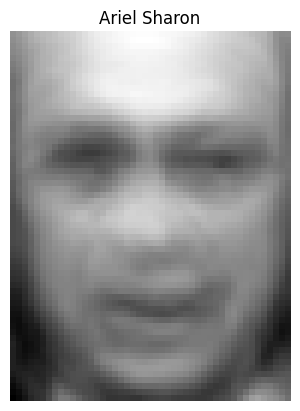

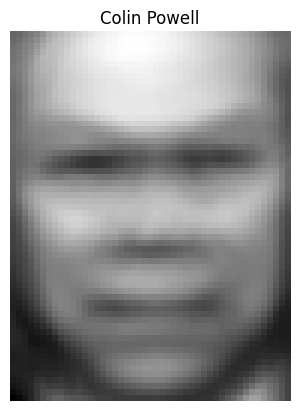

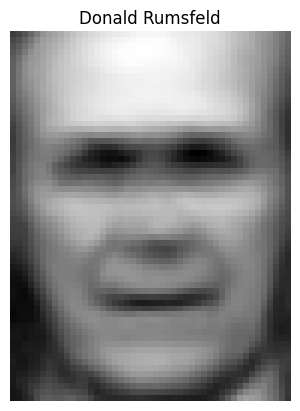

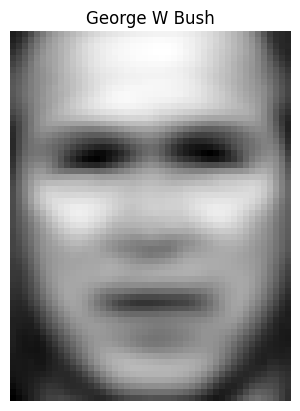

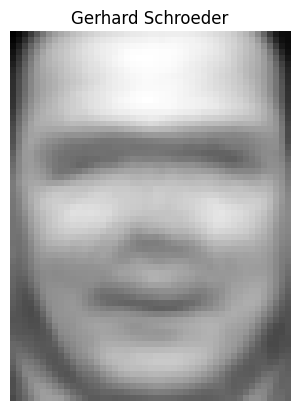

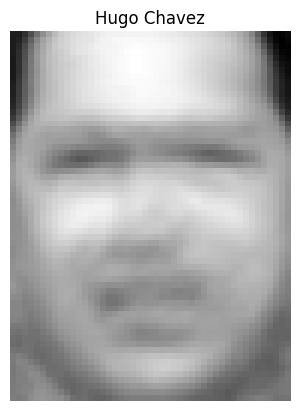

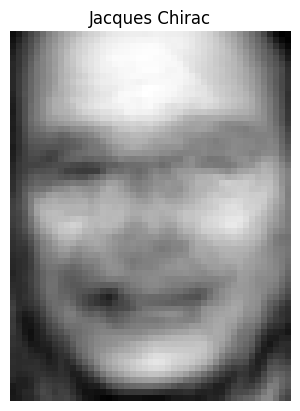

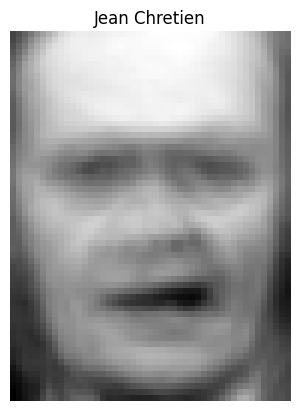

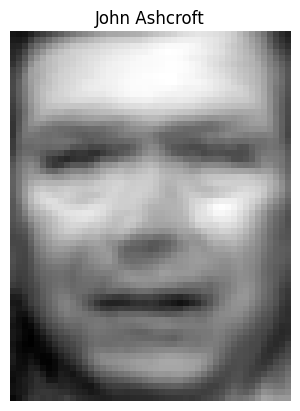

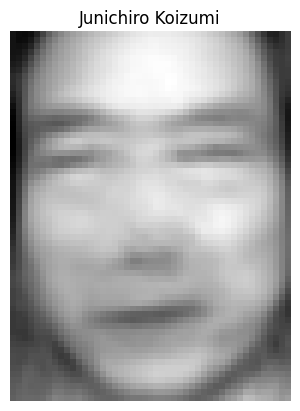

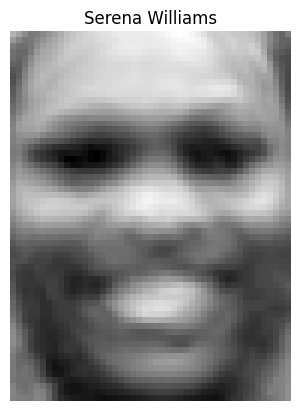

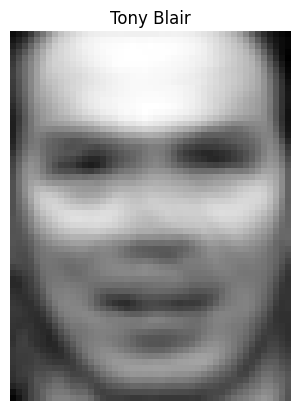

In [69]:
import os

if not os.path.exists('pictures'):
    os.makedirs('pictures')

def plot_img(row, title):
    img = row.astype('float').to_numpy().reshape(62, 47)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

persons_pics_mean_dict = {}

for index, row in mean_vectors.iterrows():
    person_name = index
    persons_pics_mean_dict[person_name] = row
    plot_img(row, person_name)


The so-called [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is often used as a measure of the "similarity" of two objects. It should not be confused with cosine distance.

Construct a similarity matrix of objects based on their averaged vectors. We recommend using a heat map for visualization, e.g. [from the seaborn library](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

<Axes: >

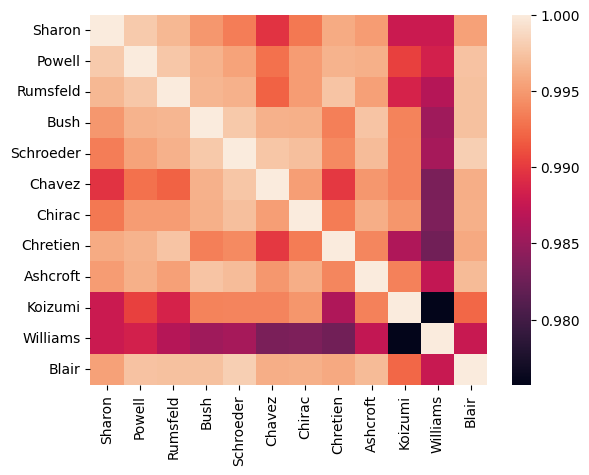

In [70]:
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import cosine_distances
import seaborn as sns

surnames = [x.split()[-1] for x in mean_vectors.index]

cos_sin_matrix = 1 - cosine_distances(mean_vectors, mean_vectors)
sns.heatmap(cos_sin_matrix, xticklabels = surnames, yticklabels =surnames)

Determine the cosine similarity for a pair of people from your individual assignment based on their corresponding "average" vectors.

In [ ]:
# < ENTER YOUR CODE HERE > 

# Построение модели

Use <code>train_test_split()</code> to split the dataset into training and test samples with the parameters from your individual assignment. Use stratification by column <code>label</code>.

In [78]:
random_state = 11

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(['label'], axis =1), df['label'], random_state =random_state)

## First approximation: a basic SVM classifier with a linear kernel

Train the <code>SVC()</code> model on the training dataset with the parameters from your individual assignment.

In [79]:
from sklearn.svm import SVC
svc = SVC(kernel = 'linear', random_state = random_state)
svc.fit(X_train, y_train)
answers = svc.predict(X_test)

Evaluate the model on test dataset. Compute <code>f1_score(average='weighted')</code>.

In [80]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

print(f1_score(y_test, answers, average = 'weighted'))

0.7728779083331344


Overall, a pretty good result, but it makes sense to try to tweak the parameters.

## Selection of hyperparameters

Using <code>GridSearchCV()</code>, perform a hyperparameter selection based on the values from your individual assignment. Observe the training time of the models.

In [74]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[11]}]


cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.744 total time=   1.0s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.754 total time=   1.0s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.804 total time=   0.9s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.769 total time=   0.9s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.808 total time=   1.0s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.357 total time=   1.3s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.362 total time=   1.3s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.347 total time=   1.3s
[CV 4/5] END C=1, class_weight=N

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [11]}],
             verbose=3)

Determine the parameters of the <b>best</b> learned model.

In [75]:
print(cv.best_params_)

{'C': 1000, 'class_weight': None, 'gamma': 0.001, 'kernel': 'rbf', 'random_state': 11}


Perform prediction for the test dataset using the best model obtained. Compute <code>f1_score(average='weighted')</code>.

In [76]:
answers = cv.predict(X_test)
print(f1_score(y_test, answers, average = 'weighted'))

0.7873693238018231


## Dimensionality reduction

Learning took a long time. It makes sense to test what happens if you reduce the dimensionality of the input dataset, e.g. by using <code>PCA</code>. Train the <code>PCA(svd_solver='full')</code> model on the training dataset and determine the minimum number of components required for the explained variance ratio to be greater than <code>0.95</code>.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(svd_solver = 'full')
pca.fit(X_train)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
min_components = np.argmax(cumulative_variance_ratio > 0.95) + 1

# Print the minimum number of components
print(f"Minimum number of components for 0.95 explained variance ratio: {min_components}")

tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[11]}]


cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)
cv.fit(X_train, y_train)

Minimum number of components for 0.95 explained variance ratio: 171
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.744 total time=   1.0s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.754 total time=   0.9s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.804 total time=   1.0s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.769 total time=   1.1s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=11;, score=0.808 total time=   1.2s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.357 total time=   1.4s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=11;, score=0.362 total time=   1.3s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=

Re-train the <code>PCA(svd_solver='full')</code> model on the training dataset using the resulting number of principal components. Apply the resulting transformation to the training and test datasets.

In [50]:
print(cv.best_params_)
print(cv.best_estimator_)

{'C': 1000, 'class_weight': None, 'gamma': 0.001, 'kernel': 'rbf', 'random_state': 11}
SVC(C=1000, gamma=0.001, random_state=11)


For the data obtained after <code>PCA</code>, similarly to what was done earlier, i.e., using the <code>GridSearchCV()</code>, select hyperparameters from the ranges specified in your individual assignment. Pay special attention to model training time.

In [81]:
from sklearn.decomposition import PCA
import numpy as np

pca= PCA(svd_solver = 'full')
pca.fit(X_train)

for index, value in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    if value>0.95:
        n_components = index+1
        print(index+1)
        break

171


Determine the parameters of the <b>best</b> model obtained.

In [ ]:
# < ENTER YOUR CODE HERE > 

Perform prediction for the test dataset using the best model obtained. Compute <code>f1_score(average='weighted')</code>.

In [84]:
from sklearn.decomposition import PCA
import numpy as np

pca= PCA(svd_solver = 'full')
pca.fit(X_train)

for index, value in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    if value>0.95:
        n_components = index+1
        print(index+1)
        break

pca = PCA(n_components = n_components, svd_solver = 'full')
X_train_pca = pca.fit_transform(X_train)

X_test_pca = pca.transform(X_test)
answers = cv.predict(X_test_pca)

print(round(f1_score(y_test, answers, average = 'weighted')))

171


C:\Users\abdur\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


ValueError: X has 171 features, but SVC is expecting 2914 features as input.

It can be seen that the quality of the model has changed only slightly, while the training time has decreased significantly.